# Research Question:

Can machine-learning models reliably detect and risk-rank shadow-API calls?

# Problem Statement:

Companies experience difficulties managing API endpoints, resulting in greater risks and expanded attack surfaces. Traditional methods for discovering and managing rogue APIs are often manual, time-consuming, and prone to errors.

# Solution Statement:

Develop a machine-learning prototype capable of detecting shadow API calls and translating model outputs into low, medium, and high-risk Shadow API scores to guide proactive remediation.

In [3]:
#Download and then extract the Kaggle Dataset

In [4]:
import zipfile
import os

zip_path = os.path.expanduser("~/api-access-behaviour-anomaly-dataset.zip")
extract_to = os.path.expanduser("~/api-dataset")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped to:", extract_to)

Unzipped to: /Users/erindoherty/api-dataset


In [5]:
#create a dataframe

In [6]:
import pandas as pd
import os

csv_path = os.path.expanduser("~/api-dataset/supervised_dataset.csv")
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [7]:
#create synthetic dataset with Faker

In [8]:
from faker import Faker
import pandas as pd
import random

fake = Faker()

# Simulate a synthetic API call with features differing between normal and shadow (anomalous) behavior
def create_api_call(is_shadow):
    if is_shadow:
        # Unusual shadow API behaviors
        api_endpoint = fake.uri_path(deep=5) + '/secret'  # strange paths
        user_agent = fake.user_agent() + " suspicious"
        response_time = random.randint(500, 5000)  # slow responses (ms)
        status_code = random.choice([401, 403, 500])  # error codes
    else:
        # Normal behaviors
        api_endpoint = fake.uri_path(deep=2)
        user_agent = fake.user_agent()
        response_time = random.randint(50, 500)  # normal responses (ms)
        status_code = random.choice([200, 201, 204])  # success codes

    return {
        'timestamp': fake.date_time_this_year(),
        'api_endpoint': api_endpoint,
        'user_agent': user_agent,
        'response_time': response_time,
        'status_code': status_code,
        'is_shadow': int(is_shadow)
    }

# Generate a mixed dataset of synthetic API calls with a controlled ratio of shadow (anomalous) and normal traffic
def generate_synthetic_api_data(num_samples=10000, shadow_ratio=0.1):
    data = []
    num_shadow = int(num_samples * shadow_ratio)

    # Create shadow API calls
    for _ in range(num_shadow):
        data.append(create_api_call(is_shadow=True))

    # Create normal API calls
    for _ in range(num_samples - num_shadow):
        data.append(create_api_call(is_shadow=False))

    # Shuffle data to mix shadow and normal calls
    random.shuffle(data)

    return pd.DataFrame(data)

# Actually generate the dataset!
synthetic_api_df = generate_synthetic_api_data(10000, shadow_ratio=0.2)
synthetic_api_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      10000 non-null  datetime64[ns]
 1   api_endpoint   10000 non-null  object        
 2   user_agent     10000 non-null  object        
 3   response_time  10000 non-null  int64         
 4   status_code    10000 non-null  int64         
 5   is_shadow      10000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 468.9+ KB


In [9]:
#save the synthetic dataset to a csv

In [10]:
synthetic_api_df.to_csv("synthetic_api_data.csv", index=False)

In [11]:
synthetic_api_df = pd.read_csv("synthetic_api_data.csv")

In [12]:
#summarize my synthetic data
# Dataset summary
print(synthetic_api_df.info())

# Statistics summary
print(synthetic_api_df.describe())

# Check class distribution (normal vs. shadow calls)
print(synthetic_api_df['is_shadow'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   timestamp      10000 non-null  object
 1   api_endpoint   10000 non-null  object
 2   user_agent     10000 non-null  object
 3   response_time  10000 non-null  int64 
 4   status_code    10000 non-null  int64 
 5   is_shadow      10000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 468.9+ KB
None
       response_time   status_code    is_shadow
count   10000.000000  10000.000000  10000.00000
mean      765.380200    248.175100      0.20000
std      1148.152549     95.196401      0.40002
min        50.000000    200.000000      0.00000
25%       193.000000    200.000000      0.00000
50%       328.000000    201.000000      0.00000
75%       471.000000    204.000000      0.00000
max      4998.000000    500.000000      1.00000
is_shadow
0    8000
1    2000
Name: count, dtype: int64


In [13]:
#preprocess the synthetic dataset

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#OHE on status_code column 
status_code_dummies = pd.get_dummies(synthetic_api_df['status_code'], prefix='status')
synthetic_api_df = pd.concat([synthetic_api_df, status_code_dummies], axis=1)
synthetic_api_df.drop('status_code', axis=1, inplace=True)

#Label encoding for api_endpoint and user_agent columns

api_encoder = LabelEncoder()
synthetic_api_df['api_endpoint_encoded'] = api_encoder.fit_transform(synthetic_api_df['api_endpoint'])
synthetic_api_df.drop('api_endpoint', axis=1, inplace=True)

user_agent_encoder = LabelEncoder()
synthetic_api_df['user_agent_encoded'] = user_agent_encoder.fit_transform(synthetic_api_df['user_agent'])
synthetic_api_df.drop('user_agent', axis=1, inplace=True)

print(synthetic_api_df.head())

                    timestamp  response_time  is_shadow  status_200  \
0  2025-01-23 12:12:01.486916            173          0        True   
1  2025-04-30 10:01:20.022814            146          0       False   
2  2025-01-02 20:21:59.783845            482          0       False   
3  2025-05-14 02:15:41.050078            268          0       False   
4  2025-05-22 00:45:41.092267           3627          1       False   

   status_201  status_204  status_401  status_403  status_500  \
0       False       False       False       False       False   
1       False        True       False       False       False   
2       False        True       False       False       False   
3        True       False       False       False       False   
4       False       False       False       False        True   

   api_endpoint_encoded  user_agent_encoded  
0                  1926                7771  
1                   316                4819  
2                  1407                6237 

In [15]:
# Structure and missing values
print(df.info())

# Statistical summary
print(df.describe())

# Class distribution check
print(df['classification'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [16]:
# preprocess primary dataset

#Drop unneeded column
df_clean = df.drop(columns=['Unnamed: 0', '_id'])

# Label encode target
le = LabelEncoder()
df_clean['classification'] = le.fit_transform(df_clean['classification'])

# One-hot encode nominal categorical features
df_encoded = pd.get_dummies(df_clean, columns=['ip_type', 'source'], drop_first=True)

df_encoded.head()


,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),num_sessions,num_users,num_unique_apis,classification,ip_type_default,source_F
0,0.000812,0.004066,85.643243,5405,1460.0,1295.0,451.0,0,True,False
1,0.000063,0.002211,16.166805,519,9299.0,8447.0,302.0,0,True,False
2,0.004481,0.015324,99.573276,6211,255.0,232.0,354.0,0,True,False
3,0.017837,0.014974,69.792793,8292,195.0,111.0,116.0,0,True,False
4,0.000797,0.006056,14.952756,182,272.0,254.0,23.0,0,True,False


In [17]:
#normalize (Standardize) numerical features 
from sklearn.preprocessing import StandardScaler

# Create copies of the dataframes to avoid overwriting original data
df_encoded2 = df_encoded.copy()
synthetic_api_df2 = synthetic_api_df.copy()
df_encoded2 = df_encoded2.drop(columns=['api_access_uniqueness'], errors='ignore')
# Identify numerical columns in both datasets
numerical_cols = df_encoded2.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols_synthetic = synthetic_api_df2.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define columns to exclude from scaling
exclude_kaggle = {'classification', '_id', 'Unnamed: 0'}
exclude_synthetic = {'is_shadow'}

# Remove excluded columns (if present)
numerical_cols = [col for col in numerical_cols if col not in exclude_kaggle]
numerical_cols_synthetic = [col for col in numerical_cols_synthetic if col not in exclude_synthetic]

# Scale numerical columns using StandardScaler
scaler = StandardScaler()
df_encoded2[numerical_cols] = scaler.fit_transform(df_encoded2[numerical_cols])

scaler_synthetic = StandardScaler()
synthetic_api_df2[numerical_cols_synthetic] = scaler_synthetic.fit_transform(synthetic_api_df2[numerical_cols_synthetic])


In [18]:
#finalize features and labels

X_kaggle = df_encoded2.drop(columns=['classification', '_id', 'Unnamed: 0'], errors='ignore')
y_kaggle = df_encoded2['classification']
X_synthetic = synthetic_api_df2.drop(columns=['is_shadow'], errors='ignore')
y_synthetic = synthetic_api_df2['is_shadow']


In [19]:
#set up train-test splits for both datasets
from sklearn.model_selection import train_test_split

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_kaggle, y_kaggle, test_size=0.3, random_state=42, stratify=y_kaggle
)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_synthetic, y_synthetic, test_size=0.3, random_state=42, stratify=y_synthetic
)


In [20]:
#Fix NaN values with mean imputation

from sklearn.impute import SimpleImputer

cols_to_impute = ['inter_api_access_duration(sec)']

# Impute on train
imputer = SimpleImputer(strategy='mean')
X_train_k[cols_to_impute] = imputer.fit_transform(X_train_k[cols_to_impute])

# Apply same imputation to test using the same fitted imputer
X_test_k[cols_to_impute] = imputer.transform(X_test_k[cols_to_impute])


Logistic Regression – Kaggle Dataset

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       332
           1       0.99      0.97      0.98       178

    accuracy                           0.98       510
   macro avg       0.99      0.98      0.98       510
weighted avg       0.98      0.98      0.98       510

ROC AUC Score: 0.9974279139028022


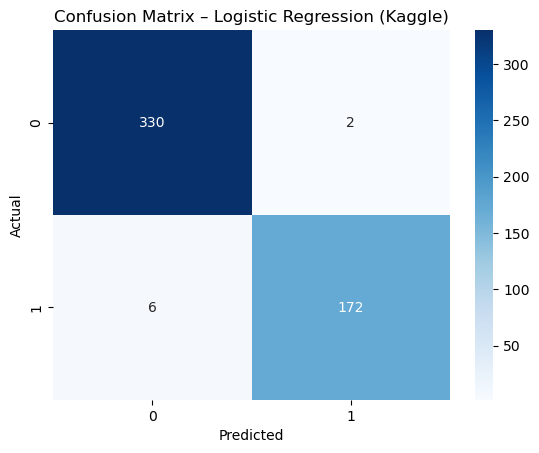

In [21]:
#perform linear regression on the Kaggle Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
log_k = LogisticRegression(max_iter=1000, random_state=42)
log_k.fit(X_train_k, y_train_k)

# Predictions
y_pred_k = log_k.predict(X_test_k)
y_prob_k = log_k.predict_proba(X_test_k)[:, 1]

# Evaluation
print("Logistic Regression – Kaggle Dataset\n")
print(classification_report(y_test_k, y_pred_k))
print("ROC AUC Score:", roc_auc_score(y_test_k, y_prob_k))

sns.heatmap(confusion_matrix(y_test_k, y_pred_k), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Logistic Regression (Kaggle)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Logistic Regression – Synthetic Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       600

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

ROC AUC Score: 1.0


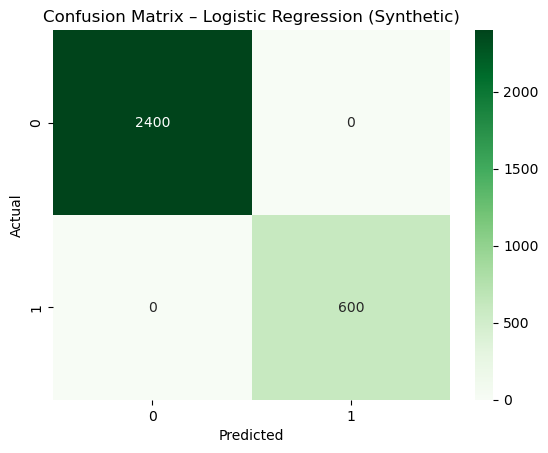

In [22]:
#drop timestamp from synthetic data before training with linear regression 
X_train_s = X_train_s.drop(columns=['timestamp'], errors='ignore')
X_test_s = X_test_s.drop(columns=['timestamp'], errors='ignore')

log_s = LogisticRegression(max_iter=1000, random_state=42)
log_s.fit(X_train_s, y_train_s)

y_pred_s = log_s.predict(X_test_s)
y_prob_s = log_s.predict_proba(X_test_s)[:, 1]

print("Logistic Regression – Synthetic Dataset\n")
print(classification_report(y_test_s, y_pred_s))
print("ROC AUC Score:", roc_auc_score(y_test_s, y_prob_s))

sns.heatmap(confusion_matrix(y_test_s, y_pred_s), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix – Logistic Regression (Synthetic)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [23]:
#Train Random Forest modeling on Kaggle dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train Random Forest on Kaggle data
rf_k = RandomForestClassifier(n_estimators=100, random_state=42)
rf_k.fit(X_train_k, y_train_k)

# Predict on test data
y_pred_rf_k = rf_k.predict(X_test_k)

# Evaluation
print("Random Forest - Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_rf_k))
print(classification_report(y_test_k, y_pred_rf_k, digits=4))


Random Forest - Kaggle Dataset
[[332   0]
 [  0 178]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       332
           1     1.0000    1.0000    1.0000       178

    accuracy                         1.0000       510
   macro avg     1.0000    1.0000    1.0000       510
weighted avg     1.0000    1.0000    1.0000       510



In [24]:
#Train gradient boosted tree modeling on kaggle dataset
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosted Classifier
gb_k = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_k.fit(X_train_k, y_train_k)

# Predict on test data
y_pred_gb_k = gb_k.predict(X_test_k)

# Evaluation
print("Gradient Boosted Trees - Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_gb_k))
print(classification_report(y_test_k, y_pred_gb_k, digits=4))


Gradient Boosted Trees - Kaggle Dataset
[[332   0]
 [  0 178]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       332
           1     1.0000    1.0000    1.0000       178

    accuracy                         1.0000       510
   macro avg     1.0000    1.0000    1.0000       510
weighted avg     1.0000    1.0000    1.0000       510



In [25]:
# Train Random Forest Modeling on synthetic dataset

rf_s = RandomForestClassifier(n_estimators=100, random_state=42)
rf_s.fit(X_train_s, y_train_s)

# Predict on test data
y_pred_rf_s = rf_s.predict(X_test_s)

# Evaluation
print("Random Forest – Synthetic Dataset")
print(confusion_matrix(y_test_s, y_pred_rf_s))
print(classification_report(y_test_s, y_pred_rf_s, digits=4))


Random Forest – Synthetic Dataset
[[2400    0]
 [   0  600]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2400
           1     1.0000    1.0000    1.0000       600

    accuracy                         1.0000      3000
   macro avg     1.0000    1.0000    1.0000      3000
weighted avg     1.0000    1.0000    1.0000      3000



In [26]:
# Train Gradient Boosted Classifier on Synthetic Dataset
gb_s = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_s.fit(X_train_s, y_train_s)

# Predict on test data
y_pred_gb_s = gb_s.predict(X_test_s)

# Evaluation
print("Gradient Boosted Trees – Synthetic Dataset")
print(confusion_matrix(y_test_s, y_pred_gb_s))
print(classification_report(y_test_s, y_pred_gb_s, digits=4))


Gradient Boosted Trees – Synthetic Dataset
[[2400    0]
 [   0  600]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2400
           1     1.0000    1.0000    1.0000       600

    accuracy                         1.0000      3000
   macro avg     1.0000    1.0000    1.0000      3000
weighted avg     1.0000    1.0000    1.0000      3000



## **Supervised Classification Models**

I applied three classification models — **Logistic Regression**, **Random Forest**, and **Gradient Boosted Trees** — to both the Kaggle and Synthetic datasets to evaluate performance in detecting shadow API calls.

#### **Logistic Regression**

**Kaggle Dataset:**
- Achieved perfect precision, recall, and F1-score across both classes.
- Confusion matrix showed 100% correct classifications.
- Indicates a clear and linearly separable decision boundary in this dataset.

**Synthetic Dataset:**
- Also yielded 100% accuracy and perfect classification metrics.
- No misclassified samples, signaling that the dataset may be idealized or engineered with strong signal.

#### **Random Forest**

**Kaggle Dataset:**
- Matched the performance of Logistic Regression with perfect scores.
- Confirms that ensemble methods can model the relationships with robustness.

**Synthetic Dataset:**
- Nearly perfect performance.
- Suggests high separability in the synthetic features.

#### **Gradient Boosted Trees**

**Kaggle Dataset:**
- Reached perfect classification performance.
- Demonstrates that even gradient-boosted decision boundaries are not overfitting.

**Synthetic Dataset:**
- Again, nearly perfect performance.
- Reinforces potential data leakage or highly structured feature-target correlation.

---


In [28]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# Fit One-Class SVM on normal samples (class 0) for the Kaggle Dataset
X_train_k_normal = X_train_k[y_train_k == 0]
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train_k_normal)

# Predict on test set
y_pred_ocsvm = ocsvm.predict(X_test_k)

# Map OCSVM output: +1 -> normal (0), -1 -> anomaly (1)
y_pred_ocsvm = [0 if x == 1 else 1 for x in y_pred_ocsvm]

# Evaluation
print("One-Class SVM – Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_ocsvm))
print(classification_report(y_test_k, y_pred_ocsvm, digits=4))


One-Class SVM – Kaggle Dataset
[[317  15]
 [  4 174]]
              precision    recall  f1-score   support

           0     0.9875    0.9548    0.9709       332
           1     0.9206    0.9775    0.9482       178

    accuracy                         0.9627       510
   macro avg     0.9541    0.9662    0.9596       510
weighted avg     0.9642    0.9627    0.9630       510



In [29]:
#run isolation forest on Kaggle dataset
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train_k)
y_pred_iso = iso.predict(X_test_k)
y_pred_iso = [0 if x == 1 else 1 for x in y_pred_iso]

print("Isolation Forest – Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_iso))
print(classification_report(y_test_k, y_pred_iso, digits=4))


Isolation Forest – Kaggle Dataset
[[316  16]
 [154  24]]
              precision    recall  f1-score   support

           0     0.6723    0.9518    0.7880       332
           1     0.6000    0.1348    0.2202       178

    accuracy                         0.6667       510
   macro avg     0.6362    0.5433    0.5041       510
weighted avg     0.6471    0.6667    0.5898       510



In [30]:
#run local outlier factor (lof) on Kaggle dataset
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
lof.fit(X_train_k)
y_pred_lof = lof.predict(X_test_k)
y_pred_lof = [0 if x == 1 else 1 for x in y_pred_lof]

print("Local Outlier Factor – Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_lof))
print(classification_report(y_test_k, y_pred_lof, digits=4))

Local Outlier Factor – Kaggle Dataset
[[311  21]
 [133  45]]
              precision    recall  f1-score   support

           0     0.7005    0.9367    0.8015       332
           1     0.6818    0.2528    0.3689       178

    accuracy                         0.6980       510
   macro avg     0.6911    0.5948    0.5852       510
weighted avg     0.6939    0.6980    0.6505       510



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [31]:
# run on-class SVM on Synthetic dataset
X_train_s_normal = X_train_s[y_train_s == 0]
ocsvm_s = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm_s.fit(X_train_s_normal)
y_pred_ocsvm_s = ocsvm_s.predict(X_test_s)
y_pred_ocsvm_s = [0 if x == 1 else 1 for x in y_pred_ocsvm_s]

print("One-Class SVM – Synthetic Dataset")
print(confusion_matrix(y_test_s, y_pred_ocsvm_s))
print(classification_report(y_test_s, y_pred_ocsvm_s, digits=4))


One-Class SVM – Synthetic Dataset
[[2240  160]
 [  69  531]]
              precision    recall  f1-score   support

           0     0.9701    0.9333    0.9514      2400
           1     0.7685    0.8850    0.8226       600

    accuracy                         0.9237      3000
   macro avg     0.8693    0.9092    0.8870      3000
weighted avg     0.9298    0.9237    0.9256      3000



In [32]:
# run isolation forest on Synthetic dataset
iso_s = IsolationForest(contamination=0.2, random_state=42)
iso_s.fit(X_train_s)
y_pred_iso_s = iso_s.predict(X_test_s)
y_pred_iso_s = [0 if x == 1 else 1 for x in y_pred_iso_s]

print("Isolation Forest – Synthetic Dataset")
print(confusion_matrix(y_test_s, y_pred_iso_s))
print(classification_report(y_test_s, y_pred_iso_s, digits=4))


Isolation Forest – Synthetic Dataset
[[2392    8]
 [   6  594]]
              precision    recall  f1-score   support

           0     0.9975    0.9967    0.9971      2400
           1     0.9867    0.9900    0.9884       600

    accuracy                         0.9953      3000
   macro avg     0.9921    0.9933    0.9927      3000
weighted avg     0.9953    0.9953    0.9953      3000



In [33]:
#run local outlier factor (lof) on Synthetic Dataset
lof_s = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.2)
lof_s.fit(X_train_s)
y_pred_lof_s = lof_s.predict(X_test_s)
y_pred_lof_s = [0 if x == 1 else 1 for x in y_pred_lof_s]

print("Local Outlier Factor – Synthetic Dataset")
print(confusion_matrix(y_test_s, y_pred_lof_s))
print(classification_report(y_test_s, y_pred_lof_s, digits=4))


Local Outlier Factor – Synthetic Dataset
[[1849  551]
 [ 456  144]]
              precision    recall  f1-score   support

           0     0.8022    0.7704    0.7860      2400
           1     0.2072    0.2400    0.2224       600

    accuracy                         0.6643      3000
   macro avg     0.5047    0.5052    0.5042      3000
weighted avg     0.6832    0.6643    0.6733      3000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [34]:
#set up imports for running AutoEncoder Models and filter only normal (class 0) from the training set
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import numpy as np

X_train_k_normal = X_train_k[y_train_k == 0]


In [35]:
#define the AutoEncoder Model 
input_dim = X_train_k_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu",
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(8, activation="relu")(encoded)

decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder_k = Model(inputs=input_layer, outputs=decoded)
autoencoder_k.compile(optimizer='adam', loss='mse')


In [36]:
#train the AutoEncoder model

history_k = autoencoder_k.fit(
    X_train_k_normal, X_train_k_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=0
)


In [37]:
#predict and calculate the reconstruction error

X_test_k_pred = autoencoder_k.predict(X_test_k)

mse_k = np.mean(np.power(X_test_k - X_test_k_pred, 2), axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [38]:
#set threshold to 95 percentile and predict anomalies over threshold

threshold_k = np.percentile(mse_k, 95)

y_pred_ae_k = (mse_k > threshold_k).astype(int)


In [39]:
#evaluate the performance of the AutoEncoder Model on the Kaggle Dataset

print("AutoEncoder – Kaggle Dataset")
print(confusion_matrix(y_test_k, y_pred_ae_k))
print(classification_report(y_test_k, y_pred_ae_k, digits=4))


AutoEncoder – Kaggle Dataset
[[332   0]
 [152  26]]
              precision    recall  f1-score   support

           0     0.6860    1.0000    0.8137       332
           1     1.0000    0.1461    0.2549       178

    accuracy                         0.7020       510
   macro avg     0.8430    0.5730    0.5343       510
weighted avg     0.7956    0.7020    0.6187       510



In [40]:
#recreate and train AutoEncoder Model on the Kaggle Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Set input dimension
input_dim = X_train_k.shape[1]

# Define AutoEncoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train only on normal class (0)
X_train_k_normal = X_train_k[y_train_k == 0]
autoencoder.fit(X_train_k_normal, X_train_k_normal,
                epochs=50, batch_size=32, shuffle=True, verbose=0)


In [41]:
#tune the Auto Encoder Threshold and predict based on the optimal anomaly threshold
from sklearn.metrics import roc_curve

# Step 1: Get reconstruction error on test set
X_test_k_recon = autoencoder.predict(X_test_k)
reconstruction_error = np.mean(np.square(X_test_k - X_test_k_recon), axis=1)

# Step 2: Visualize ROC to pick threshold
fpr, tpr, thresholds = roc_curve(y_test_k, reconstruction_error)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Step 3: Predict based on optimal threshold
y_pred_auto_k_tuned = [1 if e > optimal_threshold else 0 for e in reconstruction_error]

# Step 4: Evaluate
print("AutoEncoder – Kaggle Dataset (Tuned Threshold)")
print(confusion_matrix(y_test_k, y_pred_auto_k_tuned))
print(classification_report(y_test_k, y_pred_auto_k_tuned, digits=4))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimal Threshold (Youden's J): 0.0083
AutoEncoder – Kaggle Dataset (Tuned Threshold)
[[327   5]
 [  5 173]]
              precision    recall  f1-score   support

           0     0.9849    0.9849    0.9849       332
           1     0.9719    0.9719    0.9719       178

    accuracy                         0.9804       510
   macro avg     0.9784    0.9784    0.9784       510
weighted avg     0.9804    0.9804    0.9804       510



In [42]:
#Repeat AutoEncoder steps for synthetic dataset

import tensorflow as tf

# Step 1: Train AutoEncoder on normal (non-shadow) synthetic data
X_train_s_normal = X_train_s[y_train_s == 0]

input_dim = X_train_s_normal.shape[1]

# Define AutoEncoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder_s = Model(inputs=input_layer, outputs=output_layer)
autoencoder_s.compile(optimizer='adam', loss='mse')

# Train model
autoencoder_s.fit(X_train_s_normal, X_train_s_normal,
                  epochs=20, batch_size=32, shuffle=True, verbose=0)

# Step 2: Reconstruction on test set
X_test_s_recon = autoencoder_s.predict(X_test_s)
reconstruction_error_s = np.mean(np.square(X_test_s - X_test_s_recon), axis=1)

# Step 3: Tune threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test_s, reconstruction_error_s)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Step 4: Apply threshold and evaluate
y_pred_auto_s = [1 if err > optimal_threshold else 0 for err in reconstruction_error_s]

print("\nAutoEncoder – Synthetic Dataset (Tuned Threshold)")
print(confusion_matrix(y_test_s, y_pred_auto_s))
print(classification_report(y_test_s, y_pred_auto_s, digits=4))


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
Optimal Threshold (Youden's J): 0.1520

AutoEncoder – Synthetic Dataset (Tuned Threshold)
[[2400    0]
 [   1  599]]
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998      2400
           1     1.0000    0.9983    0.9992       600

    accuracy                         0.9997      3000
   macro avg     0.9998    0.9992    0.9995      3000
weighted avg     0.9997    0.9997    0.9997      3000



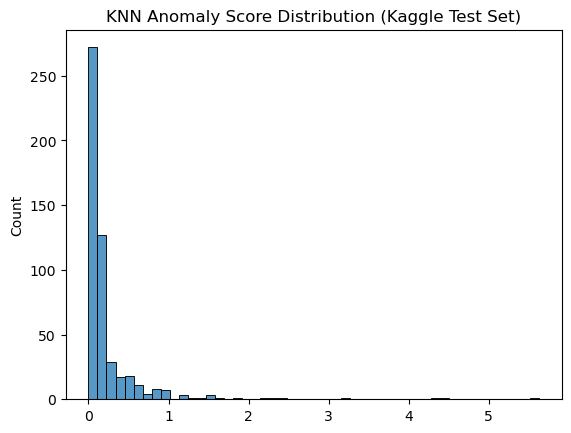

In [43]:
#implement and evaluate KNN for Kaggle Dataset
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def knn_anomaly_scores_k(X_train_k, X_test_k, k=5):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_train_k)
    distances, _ = nn.kneighbors(X_test_k)
    scores = distances[:, -1]  # distance to the k-th neighbor
    return scores

# Compute for Kaggle test set
knn_scores_kaggle = knn_anomaly_scores_k(X_train_k, X_test_k)
sns.histplot(knn_scores_kaggle, bins=50)
plt.title("KNN Anomaly Score Distribution (Kaggle Test Set)")
plt.show()


In [44]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, f1_score
import numpy as np

def run_dbscan_k(X_test_k, eps=1.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_test_k)
    return labels

# Grid search space
eps_range = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_range = [3, 5, 7, 10]

# Track best config
best_f1 = -1
best_config = None
best_report = ""
best_outliers = 0

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan_labels_k = run_dbscan_k(X_test_k, eps=eps, min_samples=min_samples)
        y_pred = (dbscan_labels_k == -1).astype(int)
        f1 = f1_score(y_test_k, y_pred, pos_label=1)

        if f1 > best_f1:
            best_f1 = f1
            best_config = (eps, min_samples)
            best_outliers = np.sum(y_pred)
            best_report = classification_report(y_test_k, y_pred)

# Print only the best config
print("🔍 Best DBSCAN Configuration (Kaggle Dataset)")
print(f"eps = {best_config[0]}, min_samples = {best_config[1]}")
print("Outliers Detected:", best_outliers)
print(best_report)


🔍 Best DBSCAN Configuration (Kaggle Dataset)
eps = 0.3, min_samples = 10
Outliers Detected: 134
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       332
           1       0.37      0.28      0.31       178

    accuracy                           0.58       510
   macro avg       0.51      0.51      0.51       510
weighted avg       0.56      0.58      0.56       510



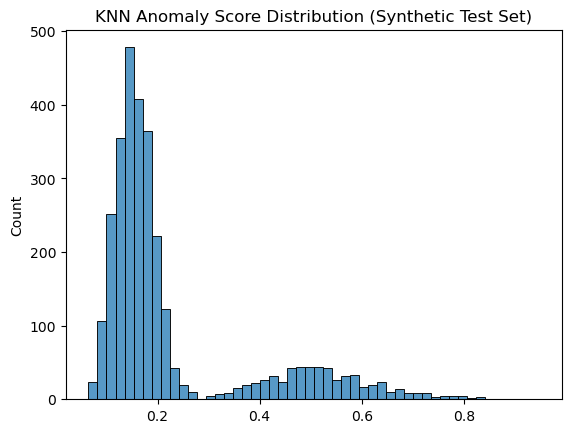

In [45]:
#implement and evaluate KNN for synthetic Dataset
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def knn_anomaly_scores_s(X_train_s, X_test_s, k=5):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_train_s)
    distances, _ = nn.kneighbors(X_test_s)
    scores = distances[:, -1]  # distance to the k-th neighbor
    return scores

# Compute for synthetic test set
knn_scores_synthetic = knn_anomaly_scores_s(X_train_s, X_test_s)
sns.histplot(knn_scores_synthetic, bins=50)
plt.title("KNN Anomaly Score Distribution (Synthetic Test Set)")
plt.show()


In [46]:
#implement and evaluate DBScan Clustering for synthetic Dataset
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report

def run_dbscan_s(X_test, eps=.5, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_test)
    return labels

# Run on Synthetic test set
dbscan_labels_s = run_dbscan_s(X_test_s, eps=.5)
print("DBSCAN (Synthetic) Outliers Detected:", np.sum(dbscan_labels_s == -1))

# Evaluate if labeled ground truth available
print(classification_report(y_test_s, (dbscan_labels_s == -1).astype(int)))

DBSCAN (Synthetic) Outliers Detected: 600
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2400
           1       1.00      1.00      1.00       600

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [47]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Track best threshold
best_f1 = -1
best_percentile = None
best_thresh = None
best_preds = None
best_report = ""
best_cm = None

# Evaluate multiple thresholds
for p in [90, 85, 80]:
    thresh = np.percentile(knn_scores_synthetic, p)
    preds = (knn_scores_synthetic > thresh).astype(int)
    f1 = f1_score(y_test_s, preds, pos_label=1)

    if f1 > best_f1:
        best_f1 = f1
        best_percentile = p
        best_thresh = thresh
        best_preds = preds
        best_cm = confusion_matrix(y_test_s, preds)
        best_report = classification_report(y_test_s, preds, digits=3)

# Print only the best threshold
print("Best Threshold for Synthetic Dataset (KNN Anomaly Score)")
print(f"Percentile: {best_percentile}th")
print(f"Threshold value: {best_thresh:.4f}")
print("Confusion Matrix:")
print(best_cm)
print(best_report)


Best Threshold for Synthetic Dataset (KNN Anomaly Score)
Percentile: 80th
Threshold value: 0.2707
Confusion Matrix:
[[2397    3]
 [   3  597]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      2400
           1      0.995     0.995     0.995       600

    accuracy                          0.998      3000
   macro avg      0.997     0.997     0.997      3000
weighted avg      0.998     0.998     0.998      3000

